C:\Users\kheli\AppData\Local\Temp\ipykernel_25396\3965070091.py:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(mask_ps), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


found 282 train images
found 4 test images
test image found
test image found
test image found
test image found


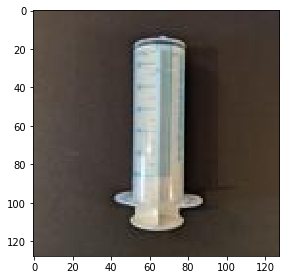

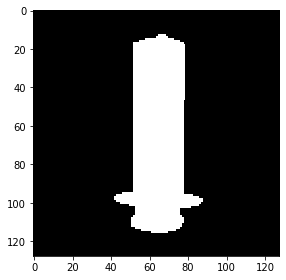

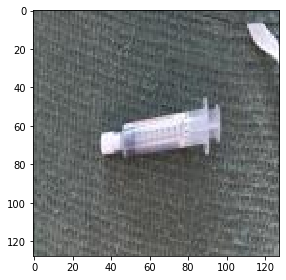

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib import cm
import glob


seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = './srngs/augmented/'
TEST_PATH = './srngs/test/resized/'

def binarize(image_to_transform, threshold):
    output = image_to_transform[:,:,:1]
    for x in range(IMG_WIDTH):

        for y in range(IMG_HEIGHT):
            if output[x,y,0] < threshold:
                output[x,y,0] =0
            else:
                output[x,y,0] = 255
    return output

def get_images_and_masks():
    im_path = TRAIN_PATH + "images/*.jpg"
    msk_path = TRAIN_PATH + "masks/*.jpg"
    im_paths = glob.glob(im_path)
    msk_paths = glob.glob(msk_path)
    return im_paths,msk_paths

im_ps,mask_ps = get_images_and_masks()
test_path = TEST_PATH + "*.jpg"
tst_ps = glob.glob(test_path)

X_train = np.zeros((len(im_ps), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(mask_ps), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((len(im_ps), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print("found "+ str(len(im_ps)) + " train images")
indx = 0
for im_p,mask_p in zip(im_ps,mask_ps):
    im_file_n, ext = os.path.splitext(im_p)
    msk_n, ext = os.path.splitext(mask_p)
    im = imread(im_p)
    msk = imread(mask_p)
    msk = binarize(msk, 190)
    X_train[indx] = im
    Y_train[indx] = msk
    indx += 1

print("found "+ str(len(tst_ps)) + " test images")
for indx,tst_p in enumerate(tst_ps):
    print("test image found")
    tst_n, ext = os.path.splitext(tst_p)
    tst = imread(tst_p)
    X_test[indx] = tst

image_x = random.randint(0, len(im_ps))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()
image_x = random.randint(0, len(tst_ps))
imshow(np.squeeze(X_test[image_x]))
plt.show()

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

## Model.Fit

Epoch 1/4
26/26 [==============================] - 2s 50ms/step - loss: 0.0794 - accuracy: 0.9699 - val_loss: 0.0324 - val_accuracy: 0.9930
Epoch 2/4
26/26 [==============================] - 1s 41ms/step - loss: 0.0776 - accuracy: 0.9701 - val_loss: 0.0300 - val_accuracy: 0.9932
Epoch 3/4
26/26 [==============================] - 1s 44ms/step - loss: 0.0754 - accuracy: 0.9707 - val_loss: 0.0300 - val_accuracy: 0.9932
Epoch 4/4
9/9 [==============================] - 0s 25ms/step
Performing a sanity check on some random training samples


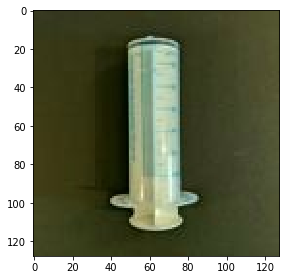

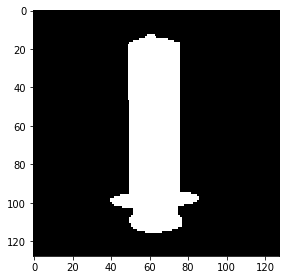

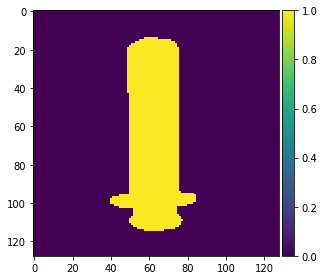

Performing a sanity check on some random validation samples


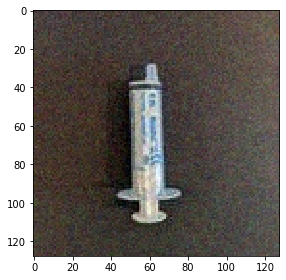

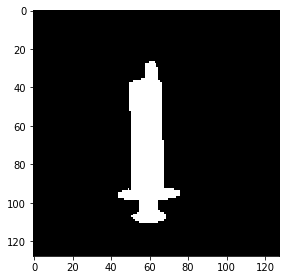

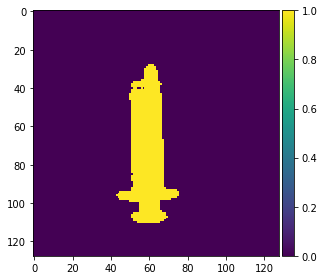

Performing a sanity check on some random test samples


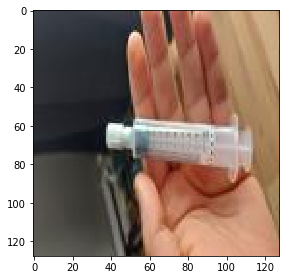

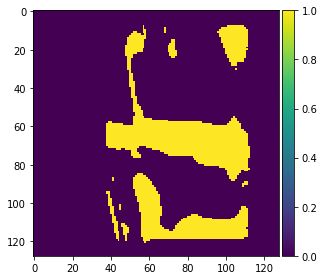

In [6]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_syringes_v0.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=10, epochs=4, callbacks=callbacks)

####################################

idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

print("Performing a sanity check on some random training samples")
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

print("Performing a sanity check on some random validation samples")
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

print("Performing a sanity check on some random test samples")
ix = random.randint(0, len(preds_test_t))
imshow(np.squeeze(X_test[0]))
plt.show()
imshow(np.squeeze(preds_test_t[0]))
plt.show()

Performing a sanity check on some random test samples


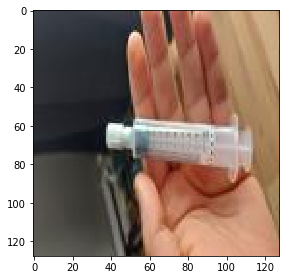

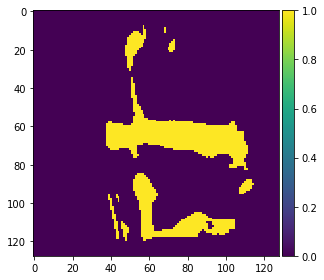

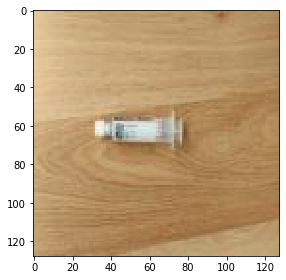

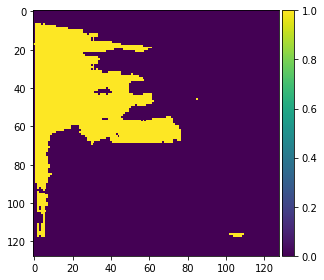

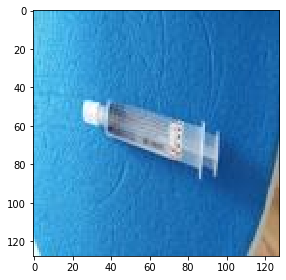

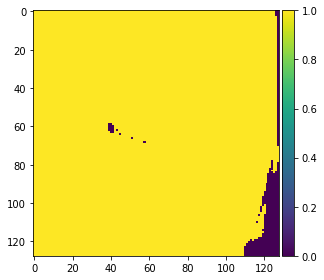

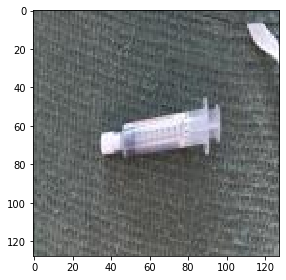

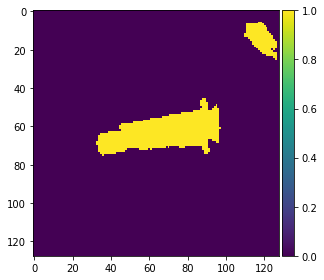

In [3]:
print("Performing a sanity check on some random test samples")
for ix in range(4):
    imshow(np.squeeze(X_test[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t[ix]))
    plt.show()